# 实现wide&deep多输入

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.data.shape)
print(housing.target.shape)



(20640, 8)
(20640,)


In [6]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(housing.data, housing.target,random_state=7)


In [7]:
from sklearn.preprocessing import StandardScaler
transfer = StandardScaler()
x_train_scaled = transfer.fit_transform(x_train)
x_test_scaled = transfer.transform(x_test)


In [22]:
#多输入
input_wide = keras.layers.Input(shape=[6],)
input_deep = keras.layers.Input(shape=[6],)
hidden1 = keras.layers.Dense(30,activation = 'relu')(input_deep)
hidden2 = keras.layers.Dense(30,activation = 'relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_wide, input_deep],
                                    outputs = [output])

model.compile(loss='mean_squared_error',
             optimizer = 'nadam',# SGD -> SGDM -> NAG ->AdaGrad -> AdaDelta -> Adam -> Nadam
             )


In [23]:
model.layers#查看模型层数

In [24]:
model.summary()#d 模型参数

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           210         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
____________________________________________________________________________________________

In [29]:
#多输入，所以拆分训练数据
x_train_scaled_wide = x_train_scaled[:,:6]
x_train_scaled_deep = x_train_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:6]
x_test_scaled_deep = x_test_scaled[:,2:]


In [26]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = model.fit([x_train_scaled_wide, x_train_scaled_deep],y_train,epochs=100,
                   validation_split=0.3,
                   callbacks= callbacks 
                   )
#validation_data:训练过程中在验证集验证

Train on 10836 samples, validate on 4644 samples
Epoch 1/100
10836/10836 [==============================] - 5s 463us/sample - loss: 1.5972 - val_loss: 0.6598
Epoch 2/100
10836/10836 [==============================] - 2s 222us/sample - loss: 0.5542 - val_loss: 0.5085
Epoch 3/100
10836/10836 [==============================] - 2s 218us/sample - loss: 0.4548 - val_loss: 0.4178
Epoch 4/100
10836/10836 [==============================] - 2s 220us/sample - loss: 0.4144 - val_loss: 0.3898
Epoch 5/100
10836/10836 [==============================] - 2s 217us/sample - loss: 0.3958 - val_loss: 0.3764
Epoch 6/100
10836/10836 [==============================] - 2s 217us/sample - loss: 0.3775 - val_loss: 0.3733
Epoch 7/100
10836/10836 [==============================] - 2s 218us/sample - loss: 0.3682 - val_loss: 0.3741
Epoch 8/100
10836/10836 [==============================] - 2s 219us/sample - loss: 0.3595 - val_loss: 0.3461
Epoch 9/100
10836/10836 [==============================] - 2s 220us/sample - lo

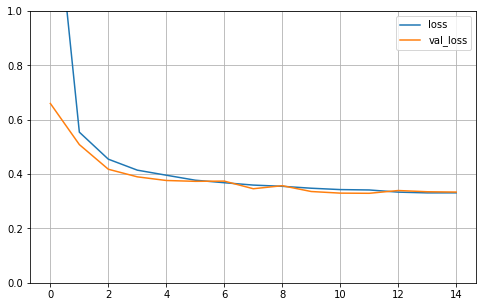

In [27]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [30]:
model.evaluate([x_test_scaled_wide,x_test_scaled_deep], y_test, verbose=2)

5160/1 - 0s - loss: 0.4576


0.3668643225071042